### Question 1: Building a small CNN model with 5 convolution layers


Install dependencies

In [4]:
!pip install pytorch-lightning torchvision wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 46.7 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

# Activation function mapping
ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "tanh": nn.Tanh,
    "sigmoid": nn.Sigmoid,
    "leaky_relu": nn.LeakyReLU,
    "gelu": nn.GELU
}

class CNN(pl.LightningModule):
    def __init__(
        self,
        input_shape=(3, 224, 224),  #3 because iNaturalist data set has RGB images
        conv_filters=[32, 64, 128, 256, 512],
        kernel_sizes=[3, 3, 3, 3, 3],
        activation='relu',
        dense_units=256,
        num_classes=10,
        learning_rate=1e-3
    ):
        super(CNN, self).__init__()
        self.save_hyperparameters()

        in_channels = input_shape[0]
        activation_cls = ACTIVATION_MAP[activation.lower()]

        self.conv_blocks = nn.Sequential()
        for i in range(5):
            self.conv_blocks.add_module(f"conv{i+1}", nn.Conv2d(
                in_channels=in_channels,
                out_channels=conv_filters[i],
                kernel_size=kernel_sizes[i],
                padding=kernel_sizes[i] // 2  #to preserve spatial dimensions
            ))
            self.conv_blocks.add_module(f"act{i+1}", activation_cls())
            self.conv_blocks.add_module(f"pool{i+1}", nn.MaxPool2d(kernel_size=2))
            in_channels = conv_filters[i]

        # Compute flattened feature size after conv layers
        dummy_input = torch.zeros(1, *input_shape)
        with torch.no_grad():
            flatten_dim = self.conv_blocks(dummy_input).view(1, -1).size(1)

        self.fc1 = nn.Linear(flatten_dim, dense_units)
        self.output = nn.Linear(dense_units, num_classes)

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.output(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def configure_optimizers(self):   #using adam optimizer
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


Hyperparameters can be changed here

In [6]:
#model woth required params
model = CNN(
    input_shape=(3, 224, 224),        # iNaturalist data set has umages of size 224*224 and RGB images
    conv_filters=[16, 32, 64, 128, 256],  #5 layers
    kernel_sizes=[3, 3, 3, 3, 3],
    activation="relu",
    dense_units=128,
    num_classes=10
)

#creating a dummy image batch (here 4 images of size 3x224x224), this is compatible with iNaturalist images
dummy_input = torch.randn(4, 3, 224, 224)

# Forward pass through the model
output = model(dummy_input)

print("Output shape:", output.shape)  #expected: (4, 10)..10 for each output. We took a batch of 4 images hence (4, 10)
print("Output logits:", output)       #scores for each class..model predicts the class with highest score


Output shape: torch.Size([4, 10])
Output logits: tensor([[-0.0209, -0.0088,  0.0203,  0.1291,  0.0828,  0.0203,  0.0609,  0.0327,
         -0.0343, -0.0112],
        [-0.0210, -0.0070,  0.0218,  0.1305,  0.0826,  0.0184,  0.0616,  0.0337,
         -0.0349, -0.0075],
        [-0.0237, -0.0056,  0.0193,  0.1302,  0.0855,  0.0205,  0.0614,  0.0330,
         -0.0336, -0.0134],
        [-0.0222, -0.0048,  0.0194,  0.1269,  0.0823,  0.0194,  0.0611,  0.0340,
         -0.0303, -0.0080]], grad_fn=<AddmmBackward0>)


# Question 2: Training iNaturalist images from scratch


In [ ]:
!wandb login
#should paste wandb API key when prompted


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: apoorvaprashanth (apoorvaprashanth-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Import Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb



Loading the data set



splitting 20% of training data to validation set and 80% as training set. Renaming val to train to avoid confusion.

I have added the zip file to MyDrive of Google Drive, change the path to load the data set correctly

In [ ]:
from google.colab import drive
import zipfile
import os
import shutil
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit

#mount Google Drive
drive.mount('/content/drive')

# Path to the ZIP file in your Google Drive
zip_path = '/content/drive/MyDrive/nature_12K.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Extract to /content/

# Original and new paths
extracted_folder = '/content/inaturalist_12K'
original_val_path = os.path.join(extracted_folder, 'val')
new_test_path = os.path.join(extracted_folder, 'test')

# Rename 'val' to 'test'
if os.path.exists(original_val_path):
    os.rename(original_val_path, new_test_path)

# Define the paths for the training data
original_train_dir = os.path.join(extracted_folder, 'train')
new_train_dir = os.path.join(extracted_folder, 'train_split')  # Keep it same
new_val_dir = os.path.join(extracted_folder, 'val_split')  # This will be used for new validation data

# Load the samples and labels using ImageFolder
dataset = ImageFolder(root=original_train_dir)
samples = dataset.samples  # List of (path, class_index)
labels = [label for _, label in samples]

# Perform a stratified split (80% train, 20% validation)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(samples, labels))

train_samples = [samples[i] for i in train_idx]
val_samples = [samples[i] for i in val_idx]

# Create new folders for the validation set and training set
for class_name in dataset.classes:
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(new_val_dir, class_name), exist_ok=True)

# Copy files to the new training folders
for path, label in train_samples:
    class_name = dataset.classes[label]
    dest = os.path.join(new_train_dir, class_name, os.path.basename(path))
    shutil.copy2(path, dest)

# Copy files to the new validation folders
for path, label in val_samples:
    class_name = dataset.classes[label]
    dest = os.path.join(new_val_dir, class_name, os.path.basename(path))
    shutil.copy2(path, dest)

print(f"Data prepared with 80% training and 20% validation split. The test data remains in: {new_test_path}")


Mounted at /content/drive
Data prepared with 80% training and 20% validation split. The test data remains in: /content/inaturalist_12K/test


CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score

class LitCNN(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters(config)
        self.accuracy = Accuracy(task='multiclass', num_classes=config["num_classes"])
        self.f1 = F1Score(task='multiclass', num_classes=config["num_classes"], average='weighted')

        # Activation functions mapping
        activations = {
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
            "silu": nn.SiLU(),
            "mish": nn.Mish()
        }
        act_fn = activations[config['activation']]

        channels = [3] + config['filters']
        kernel_size = config['kernel_size']

        layers = []
        for i in range(5):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=kernel_size, padding=kernel_size//2))
            if config.get("batch_norm", False):
                layers.append(nn.BatchNorm2d(channels[i+1]))
            layers.append(act_fn)
            layers.append(nn.MaxPool2d(2))
            if config.get("dropout", 0.0) > 0:
                layers.append(nn.Dropout(config["dropout"]))

        self.conv = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(config['filters'][-1] * 7 * 7, config['dense_neurons'])  # Assuming 224x224 input
        self.fc2 = nn.Linear(config['dense_neurons'], 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

    def test_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update and log metrics
        acc = self.accuracy(preds, y)
        f1 = self.f1(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)

        return {"loss": loss}


Data Augumentation

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl

class InatDataModule(pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir, batch_size=64, augment=False):
        super().__init__()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.augment = augment

    def setup(self, stage=None):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        base_transforms = [transforms.Resize((224, 224)), transforms.ToTensor(), normalize]
        if self.augment:
            train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.RandomResizedCrop(224),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            train_transform = transforms.Compose(base_transforms)

        val_test_transform = transforms.Compose(base_transforms)

        self.train_dataset = ImageFolder(self.train_dir, transform=train_transform)
        self.val_dataset = ImageFolder(self.val_dir, transform=val_test_transform)
        self.test_dataset = ImageFolder(self.test_dir, transform=val_test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)


Training the Model

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer, callbacks
from pytorch_lightning.callbacks import ModelCheckpoint

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config

        if "num_classes" not in config:
            config.num_classes = 10  # for task in Accuracy

        run_name = f"f{config.filters}_k{config.kernel_size}_{config.activation}_do{config.dropout}_bn{config.batch_norm}_bs{config.batch_size}_dense{config.dense_neurons}"
        wandb.run.name = run_name

        # Data
        data = InatDataModule(
            train_dir="/content/inaturalist_12K/train_split",
            val_dir="/content/inaturalist_12K/val_split",
            test_dir="/content/inaturalist_12K/test",
            batch_size=config.batch_size,
            augment=config.augment
        )

        # Model
        model = LitCNN(dict(config))


        # Logger
        logger = WandbLogger(project="iNaturalist_CNN_da6401_A2")

        # Checkpoint callback
        checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            dirpath="./checkpoints",
            filename="best_model",
            save_top_k=1,
            mode="min"
        )


        # Trainer with early stopping
        es_callback = callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        trainer = Trainer( max_epochs=config.epochs, logger=logger, accelerator="gpu",devices=1,callbacks=[es_callback, checkpoint_callback])
        trainer.fit(model, datamodule=data)



Confined sweep startegy discussed in W&B report

In [ ]:
# W&B Sweep Configuration Cell for iNaturalist CNN (DA6401 A2)
import wandb

sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'filters': {
            'values': [
                [64, 64, 128, 128, 128],
                [64, 64, 64, 64, 64],
                [64, 64, 128, 256, 256],
            ]
        },
        'kernel_size': {
            'values': [3, 5]
        },
        'activation': {
            'values': ['silu', 'mish']
        },
        'batch_norm': {
            'values': [True, False]
        },
        'dropout': {
            'values': [0, 0.2, 0.3]
        },
        'dense_neurons': {
            'values': [128, 256, 512]
        },
        'lr': {'max':1e-2, 'min':1e-6},
        'augment': {
            'values': [True, False]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'epochs': {
            'values': [5, 10]
        }
    }
}

# Create sweep
sweep_id = wandb.sweep(sweep_config, project="iNaturalist_CNN_da6401_A2")
print("Sweep ID:", sweep_id)


In [ ]:
wandb.agent(sweep_id, function=train_model, count=10)


Sweep using the best model parameters (can be obtained by downloading the config file of the best performing model (with the highest validation accuracy))

In [ ]:
#Hyper params of the best performing model
import wandb

sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'filters': {
            'values': [
                [64, 64, 128, 128, 128],
            ]
        },
        'kernel_size': {
            'values': [3]
        },
        'activation': {
            'values': ['mish']
        },
        'batch_norm': {
            'values': [True]
        },
        'dropout': {
            'values': [0.0]
        },
        'dense_neurons': {
            'values': [128]
        },
        'lr': {'max':0.0025, 'min':0.002},
        'augment': {
            'values': [False]
        },
        'batch_size': {
            'values': [64]
        },
        'epochs': {
            'values': [15]
        }
    }
}

# Create sweep
sweep_id = wandb.sweep(sweep_config, project="iNaturalist_CNN_da6401_A2")
print("Sweep ID:", sweep_id)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 8m7dy7jn
Sweep URL: https://wandb.ai/apoorvaprashanth-indian-institute-of-technology-madras/iNaturalist_CNN_da6401_A2/sweeps/8m7dy7jn
Sweep ID: 8m7dy7jn


Train the best model

In [ ]:
wandb.agent(sweep_id, function=train_model, count=1)


wandb: Agent Starting Run: 81dol4as with config:
wandb: 	activation: mish
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	filters: [64, 64, 128, 128, 128]
wandb: 	kernel_size: 3
wandb: 	lr: 0.0024763803811355435
wandb: Currently logged in as: apoorvaprashanth (apoorvaprashanth-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | f1       | MulticlassF1Score  | 0      | train
2 | conv     | Sequential         | 408 K  | train
3 | flatten  | Flatten            | 0      | train
4 | fc1      | Linear             | 802 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
train_acc,▁▃▃▃▅▃▂▃▃▄▃▃▄▃▃▅▄▅▅▆▅▃▅▄▅▅▄▅▄▅▅▆▅▅██▆
train_loss,█▇█▇▆▆▇▆▆▅▇▆▅▇▇▅▅▅▅▄▅▆▄▅▄▃▅▄▅▄▃▃▄▃▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▂▄▆▅▆█▅▇▆█▇▇█
val_loss,█▅▅▃▂▂▂▁▄▂▂▁▃▇▄
epoch,14
train_acc,0.46875
train_loss,1.34956
trainer/global_step,1874
val_acc,0.359


Question 4 (Accuracy on test data set using the best model hyperparamerters)

In [ ]:
# Load data
data = InatDataModule(
    train_dir="/content/inaturalist_12K/train_split",
    val_dir="/content/inaturalist_12K/val_split",
    test_dir="/content/inaturalist_12K/test",
    batch_size=64,
    augment=False
)

# Call setup explicitly to initialize datasets
data.setup()

# Load model
model = LitCNN.load_from_checkpoint("./checkpoints/best_model.ckpt")

# Create trainer
trainer = Trainer(accelerator="gpu", devices=1)

# Run test
test_metrics = trainer.test(model, dataloaders=data.test_dataloader())
print("Test Accuracy:", test_metrics[0]["test_acc"])




INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3765000104904175     │
│          test_f1          │    0.5278162956237793     │
│         test_loss         │    1.8306684494018555     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 0.3765000104904175


Some images(First 10 images) and the cprrect label vs the prediction with prediction confidence

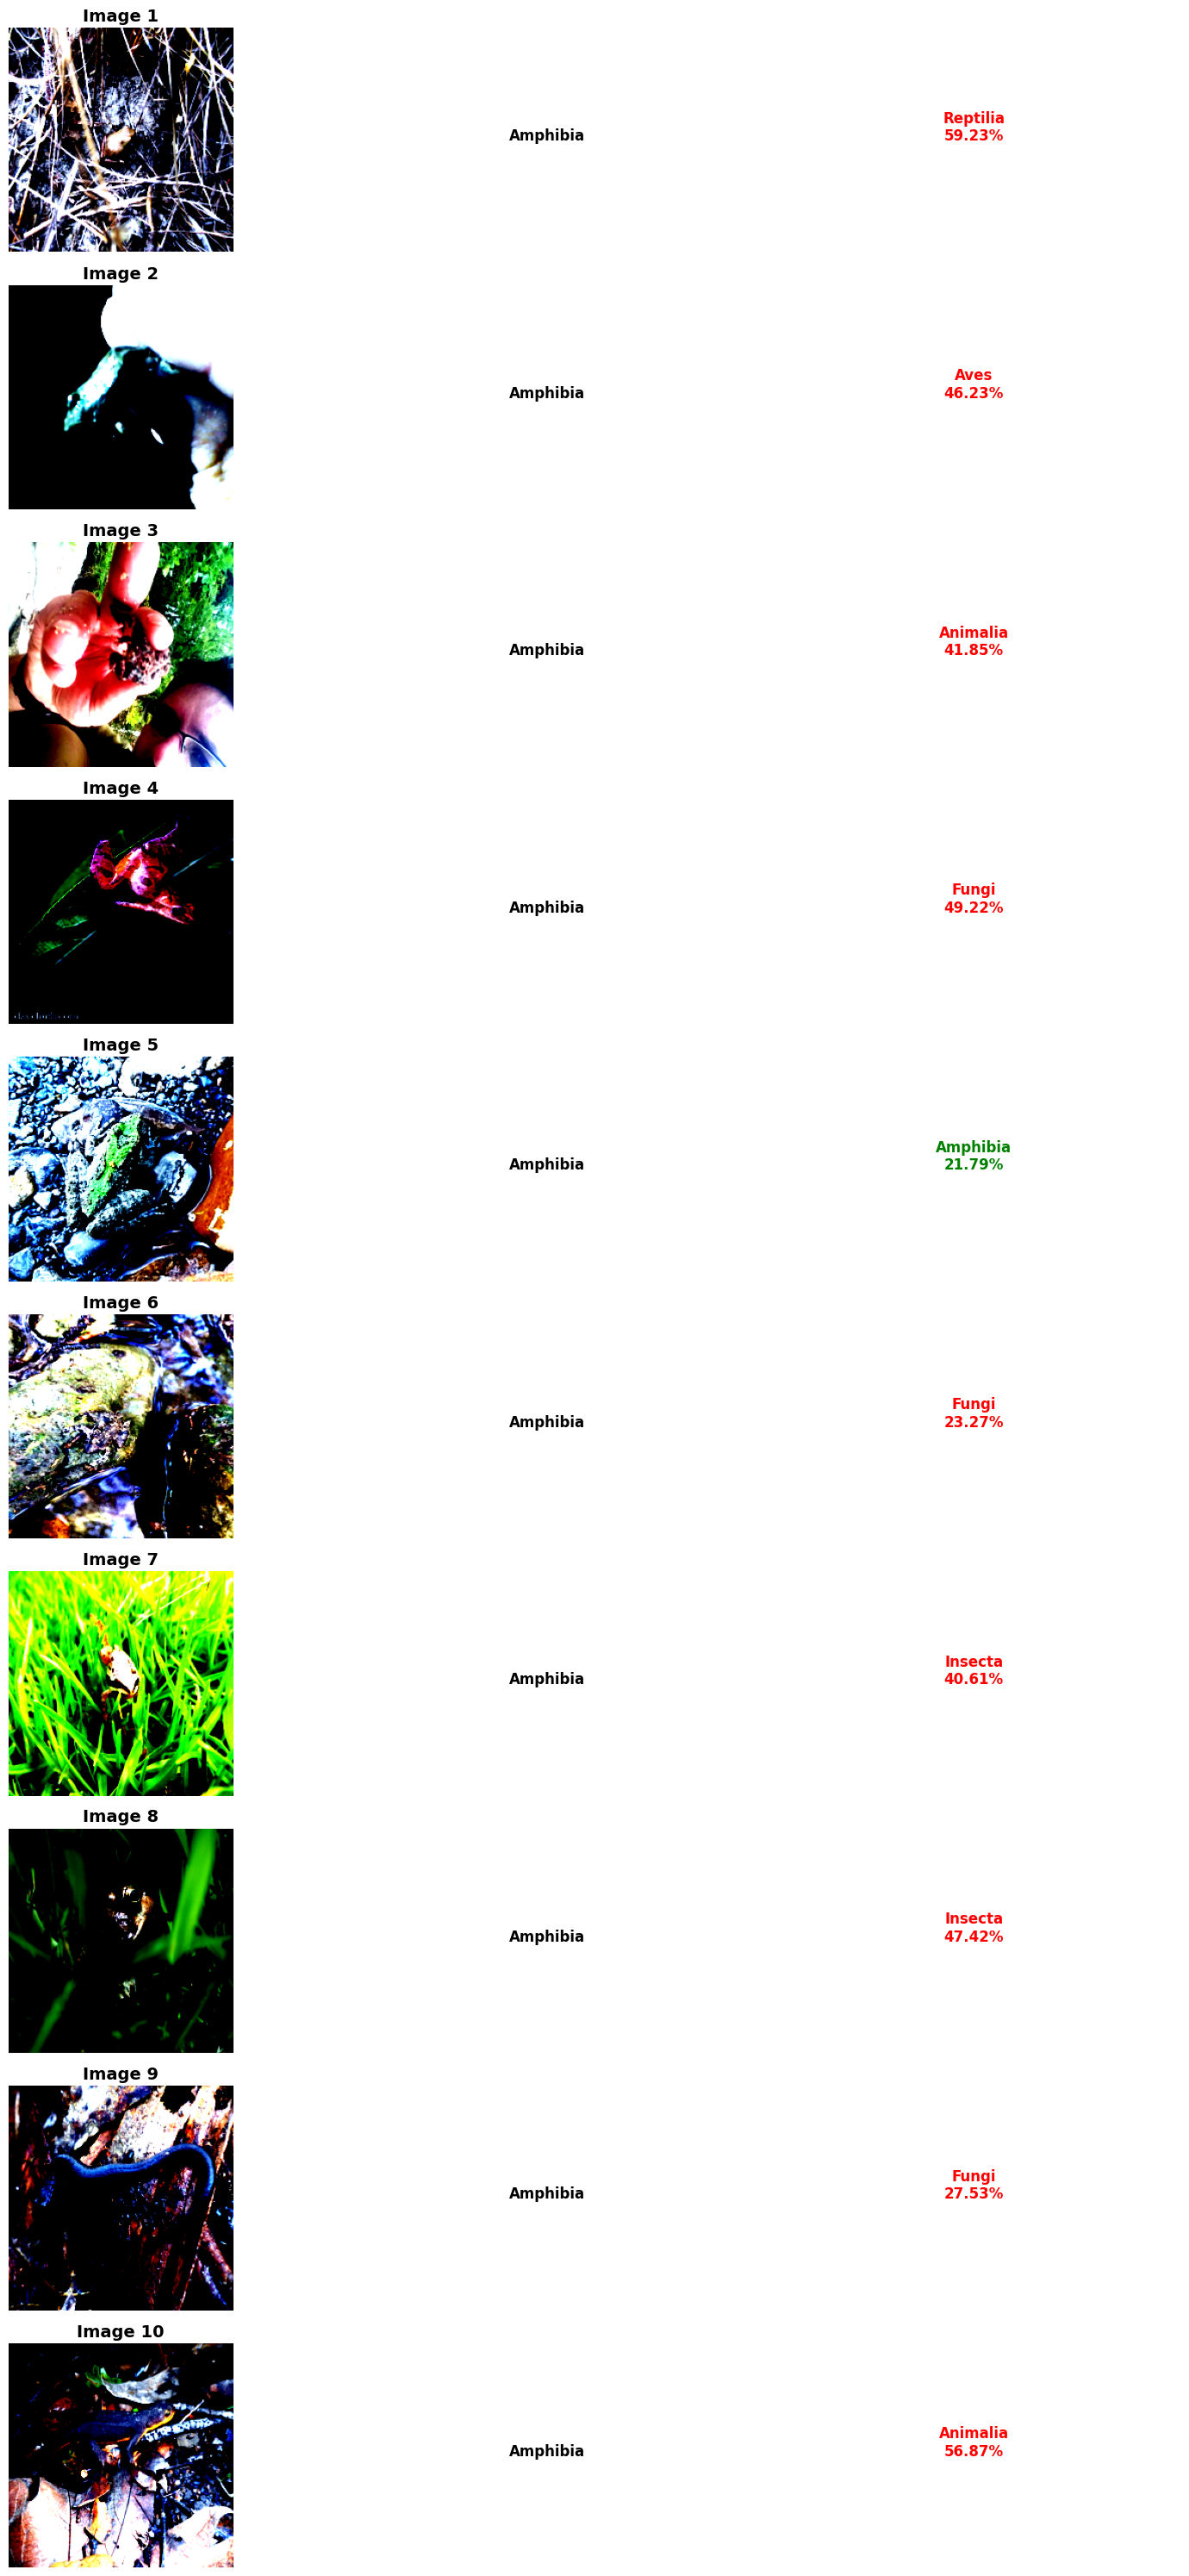

In [ ]:
import matplotlib.pyplot as plt
import torch

# Get test dataloader from the data module
test_dataloader = data.test_dataloader()
test_dataset = data.test_dataset  # needed for class names

# Get one batch of data
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move images to the correct device (same as model)
device = next(model.parameters()).device
images, labels = images.to(device), labels.to(device)

# Generate predictions
with torch.no_grad():
    logits = model(images)
    predictions = torch.argmax(logits, dim=1)

# Get the true/predicted labels as class names
class_names = test_dataset.classes
predicted_labels = [class_names[pred.item()] for pred in predictions]
true_labels = [class_names[label.item()] for label in labels]

# Plotting
fig, axes = plt.subplots(10, 3, figsize=(15, 30))  # 10x3 grid
for i in range(10):
    ax = axes[i, 0]
    ax.imshow(images[i].cpu().permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    ax.set_title(f"Image {i+1}", fontsize=14, weight='bold', color='black')
    ax.axis('off')

    ax = axes[i, 1]
    ax.text(0.5, 0.5, true_labels[i], fontsize=12, ha='center', fontweight='bold', color='black', backgroundcolor='white')
    ax.axis('off')

    ax = axes[i, 2]
    confidence = torch.softmax(logits, dim=1)[i, predictions[i]].item()
    ax.text(0.5, 0.5, f"{predicted_labels[i]}\n{confidence*100:.2f}%",
            fontsize=12, ha='center', color='green' if true_labels[i] == predicted_labels[i] else 'red',
            fontweight='bold', backgroundcolor='white')
    ax.axis('off')

plt.tight_layout()

with wandb.init(project="iNaturalist_CNN_da6401_A2", name="test_predictions") as run:
    wandb.log({
        "test_predictions_grid": wandb.Image(fig)
    })


#  Show the figure locally
plt.show()


Randomly chosen 10 images from test set, can be found in *runs>test_image>files>media>images*

In [ ]:
import matplotlib.pyplot as plt
import torch
import wandb
import random

# Start W&B
wandb.init(project="iNaturalist_CNN_da6401_A2", name="test_image")

# Get test dataloader and dataset
test_dataloader = data.test_dataloader()
test_dataset = data.test_dataset

# Get one batch
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move to device
device = next(model.parameters()).device
images, labels = images.to(device), labels.to(device)

# Predict
with torch.no_grad():
    logits = model(images)
    predictions = torch.argmax(logits, dim=1)

# Class labels
class_names = test_dataset.classes
predicted_labels = [class_names[pred.item()] for pred in predictions]
true_labels = [class_names[label.item()] for label in labels]

# Pick 10 random indices
random_indices = random.sample(range(len(images)), 10)

# Plot
fig, axes = plt.subplots(10, 3, figsize=(15, 30))
for i, idx in enumerate(random_indices):
    ax = axes[i, 0]
    ax.imshow(images[idx].permute(1, 2, 0).cpu())  # Added `.cpu()` for safety
    ax.set_title(f"Image {i+1}", fontsize=14, weight='bold')
    ax.axis('off')

    ax = axes[i, 1]
    ax.text(0.5, 0.5, true_labels[idx], fontsize=12, ha='center', fontweight='bold',
            color='black', backgroundcolor='white')
    ax.axis('off')

    ax = axes[i, 2]
    confidence = torch.softmax(logits[idx], dim=0)[predictions[idx]].item()
    ax.text(0.5, 0.5, f"{predicted_labels[idx]}\n{confidence*100:.2f}%",
            fontsize=12, ha='center',
            color='green' if true_labels[idx] == predicted_labels[idx] else 'red',
            fontweight='bold', backgroundcolor='white')
    ax.axis('off')

plt.tight_layout()
plt.show()
# Save the figure BEFORE closing it or showing it
plt.savefig("predictions_grid.png")
plt.close()

# Log to wandb
wandb.log({"Predicted Grid": wandb.Image("predictions_grid.png")})

# Finish run
wandb.finish()
